In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed
import pickle as pkl

In [7]:
df_path = '/home/munz/school/big_data/data/train.csv'
df = pd.read_csv(df_path)

df = df[df['chain'] != 0]

df_grouped = df.groupby('hotel_id').agg({'image': 'count', 'chain': 'first'}).reset_index()
df_grouped = df_grouped.sort_values(by='image', ascending=False)
top_100_hotel_ids = df_grouped['hotel_id'].values[:100]
df = df[df['hotel_id'].isin(top_100_hotel_ids)].reset_index(drop=True)

In [ ]:
chains = df['chain'].unique().astype(str)
train_images_path = '/home/munz/school/big_data/data/train_images'
folder_names_in_train_images_path = os.listdir(train_images_path)

for folder_name in folder_names_in_train_images_path:
    if folder_name not in chains:
        os.system(f'rm -rf {os.path.join(train_images_path, folder_name)}')

In [9]:
image_to_hotel_id = {}
for i, image in enumerate(df['image']):
    image_to_hotel_id[image] = df['hotel_id'][i]

hotel_id_to_label = {}
for i, hotel_id in enumerate(df['hotel_id'].unique()):
    hotel_id_to_label[hotel_id] = i

image_to_label = {}
for image, hotel_id in image_to_hotel_id.items():
    image_to_label[image] = hotel_id_to_label[hotel_id]

In [13]:
def load_and_resize_image(image_path, size):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h, w = image.shape[:2]
    scale = min(size[0] / h, size[1] / w)
    new_h, new_w = int(h * scale), int(w * scale)

    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    delta_h = size[0] - new_h
    delta_w = size[1] - new_w
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    color = [0, 0, 0]
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
    return image

def load_images(images_path, image_to_label, size=(224, 224), max_workers=4):
    images = []
    labels = []
    image_paths = []

    # Collect all image paths
    for root, _, files in tqdm(os.walk(images_path), desc="Collecting image paths"):
        for image_name in files:
            if image_name in image_to_label:
                image_path = os.path.join(root, image_name)
                image_paths.append((image_path, image_to_label[image_name]))

    # Use ThreadPoolExecutor to parallelize the image loading process
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(load_and_resize_image, image_path, size): label for image_path, label in image_paths}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Loading images"):
            image = future.result()
            if image is not None:
                images.append(image)
                labels.append(futures[future])

    return np.array(images), np.array(labels)

In [14]:
train_images_path = '/home/munz/school/big_data/data/train_images'
target_size = (512, 512)
images, labels = load_images(train_images_path, image_to_hotel_id, size=target_size, max_workers=6)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

Loading images: 100%|██████████| 7605/7605 [01:11<00:00, 106.84it/s]


In [25]:
def horizontal_flip(image):
    flipped_image = cv2.flip(image, 1)
    return flipped_image

def rotate_image(image, angle_range=(-30, 30)):
    angle = np.random.uniform(low=angle_range[0], high=angle_range[1])
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, M, (w, h))
    return rotated_image

def adjust_brightness(image, factor_range=(0, 2)):
    factor = np.random.uniform(low=factor_range[0], high=factor_range[1])
    adjusted_image = cv2.convertScaleAbs(image, alpha=factor, beta=0)
    return adjusted_image

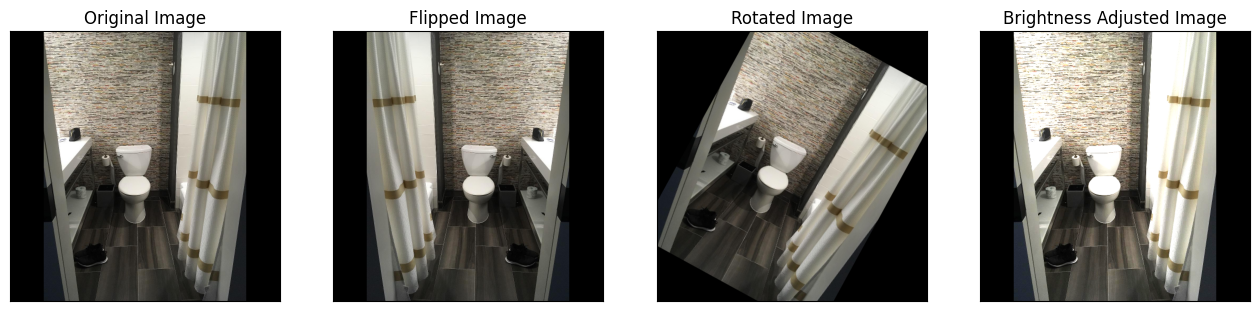

In [35]:
image_0 = X_train[9]
flipped_image = horizontal_flip(image_0)
rotated_image = rotate_image(image_0, angle_range=(-30, 30))
brightness_adjusted_image = adjust_brightness(image_0, factor_range=(0.5, 1.5))

fig, ax = plt.subplots(1, 4, figsize=(16,6))
ax[0].imshow(image_0)
ax[0].set_title('Original Image')
ax[1].imshow(flipped_image)
ax[1].set_title('Flipped Image')
ax[2].imshow(rotated_image)
ax[2].set_title('Rotated Image')
ax[3].imshow(brightness_adjusted_image)
ax[3].set_title('Brightness Adjusted Image')

# remove the x and y ticks
for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.show()